In [107]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

In [16]:
#Data preprocessing
path = './data'
prokaryotes = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))
proteinnames = prokaryotes.copy()['Protein_ID']
droplist = [0,1,2,3,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35,36,37,40,41,42,45,282,283,284,285,286,287,288,289,290,291,292,293,294,300,301,302,303,304,305,306,327]
prokaryotes = prokaryotes.drop(prokaryotes.columns[droplist], axis=1)
prokaryotes.replace([np.inf, -np.inf], np.nan, inplace=True)
prokaryotes = prokaryotes.fillna(0)
prokaryotes = prokaryotes.reset_index(drop=True)
meltPoints = prokaryotes['meltPoint']
prokaryotes = prokaryotes.drop('meltPoint', axis=1)

C:\Users\tobia\AppData\Local\Temp\ipykernel_5212\4196147237.py:3: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))


In [127]:
model = joblib.load('./data/gbr_model1.joblib')
pca = joblib.load('./data/pca1.joblib')
scaler = joblib.load('./data/scaler1.joblib')
prokaryotes1 = joblib.load('./data/prokaryotes1.joblib')
prokaryotesscaled = scaler.transform(prokaryotes)
prokaryotespca = pca.transform(prokaryotesscaled)
meltdf = pd.DataFrame({'Protein': proteinnames, 'meltPointpred': model.predict(prokaryotespca), 'meltPoint' : meltPoints})

In [22]:
meltdf['diff'] = meltdf['meltPoint'] - meltdf['meltPointpred']
MSE = mean_squared_error(meltdf['meltPoint'], meltdf['meltPointpred'])
RMSE = np.sqrt(MSE)
RMSE

7.4058358911206135

In [52]:
########## temperature dependent error of the model ########## mppred range: 38-92
meltdf['predround'] = meltdf['meltPointpred'].round()
def calculate_rmse(group):
    rmse = np.sqrt(mean_squared_error(group['meltPoint'], group['meltPointpred']))
    count = len(group)
    return pd.Series({'RMSE': rmse, 'Count': count})
grouped_rmse = meltdf.groupby('predround').apply(lambda x: calculate_rmse(x))
print(grouped_rmse)

                RMSE  Count
predround                  
38.0       23.697649    1.0
39.0        4.073442    1.0
40.0       18.367629    1.0
41.0        2.991419   12.0
42.0        3.848261   42.0
43.0        4.238201  115.0
44.0        4.961298  394.0
45.0        4.597055  621.0
46.0        5.891450  737.0
47.0        6.165390  728.0
48.0        6.429005  642.0
49.0        7.462576  448.0
50.0        8.546831  306.0
51.0        7.710999  188.0
52.0        9.075649  131.0
53.0       12.005849   93.0
54.0       10.022352   71.0
55.0       12.797793   53.0
56.0       12.959594   65.0
57.0       13.964135   44.0
58.0       12.731700   50.0
59.0       14.146660   46.0
60.0       14.566805   43.0
61.0       15.691045   46.0
62.0       14.126571   33.0
63.0       14.848709   41.0
64.0       13.552377   45.0
65.0       12.309278   41.0
66.0        9.404451   44.0
67.0        9.899420   62.0
68.0        7.956320   81.0
69.0        6.544686   87.0
70.0        7.107411   98.0
71.0        7.417626

C:\Users\tobia\AppData\Local\Temp\ipykernel_5212\3480559239.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = meltdf.groupby('predround').apply(lambda x: calculate_rmse(x))


In [142]:
prokaryotes348 = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))

C:\Users\tobia\AppData\Local\Temp\ipykernel_5212\2432898940.py:1: DtypeWarning: Columns (6,19,20,21,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  prokaryotes348 = pd.read_csv(os.path.join(path, 'prokaryotes_348columns.csv'))


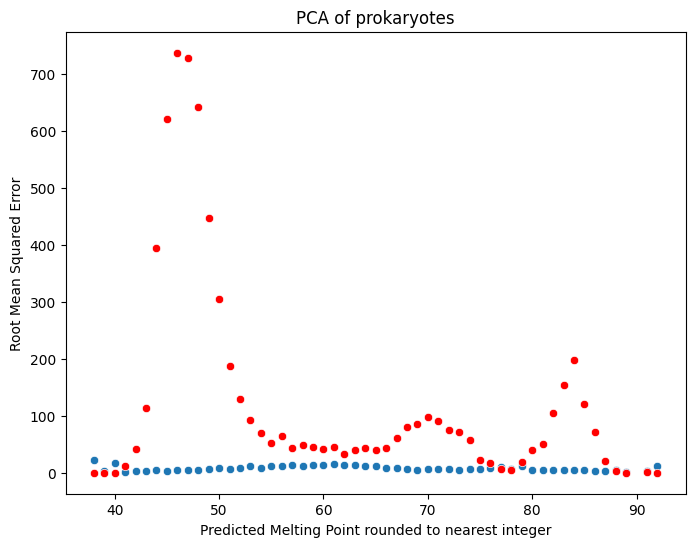

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=grouped_rmse, x = 'predround', y = 'RMSE')
sns.scatterplot(data=grouped_rmse, x = 'predround', y = 'Count', c = 'red')
#sns.scatterplot(data = prokaryotes_PCA_df, x = 'PC1', y = 'PC3', hue = 'meltPoint',palette = 'deep')
plt.xlabel('Predicted Melting Point rounded to nearest integer')
plt.ylabel('Root Mean Squared Error')
plt.title('PCA of prokaryotes')
plt.show()

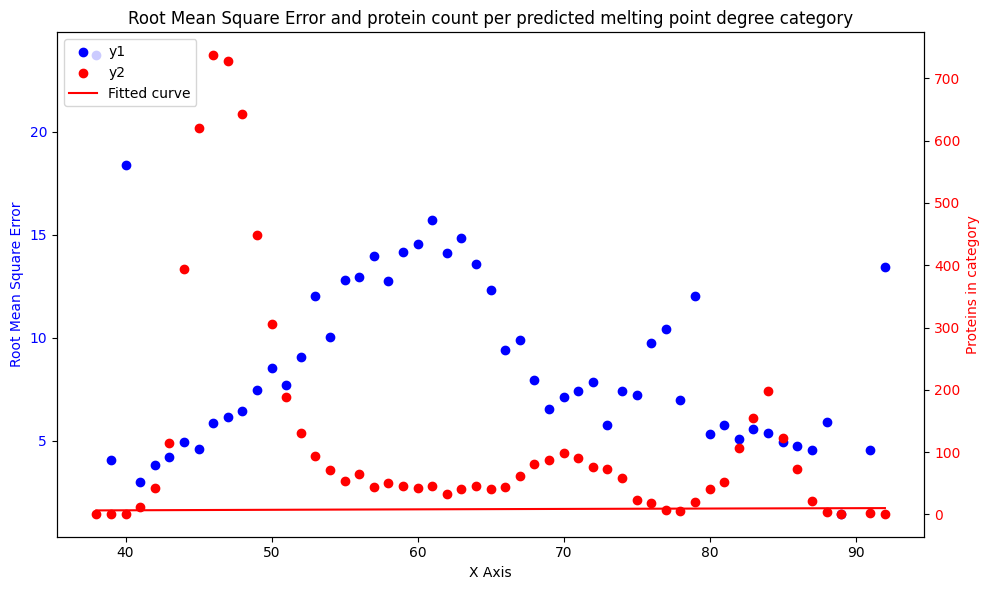

In [70]:
from scipy.optimize import curve_fit
def model_func(x, a,b,c,d,e,f,g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g


fig, ax1 = plt.subplots(figsize=(10, 6))
# Scatter plot for y1
ax1.scatter(data =grouped_rmse, x = grouped_rmse.index, y = 'RMSE', color='blue', label='y1')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Root Mean Square Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.scatter(data =grouped_rmse, x = grouped_rmse.index, y = 'Count', color='red', label='y2')
ax2.set_ylabel('Proteins in category', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legends
plt.plot(grouped_rmse.index, y_pred, color='red', label='Fitted curve')
plt.title('Root Mean Square Error and protein count per predicted melting point degree category')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

plt.show()

In [74]:
grouped_rmse.to_excel('./data/grouped_rmse.xlsx',index = False)

In [95]:
binsize = 4
bins = list(range(38, 93,binsize))
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
meltdf['rounded2'] = pd.cut(meltdf['meltPointpred'], bins, labels=labels)
grouped_rmse2 = meltdf.groupby('rounded2').apply(lambda x: calculate_rmse(x))
print(grouped_rmse2)

In [156]:
np.arange(38,93,0.1)

array([38. , 38.1, 38.2, 38.3, 38.4, 38.5, 38.6, 38.7, 38.8, 38.9, 39. ,
       39.1, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7, 39.8, 39.9, 40. , 40.1,
       40.2, 40.3, 40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41. , 41.1, 41.2,
       41.3, 41.4, 41.5, 41.6, 41.7, 41.8, 41.9, 42. , 42.1, 42.2, 42.3,
       42.4, 42.5, 42.6, 42.7, 42.8, 42.9, 43. , 43.1, 43.2, 43.3, 43.4,
       43.5, 43.6, 43.7, 43.8, 43.9, 44. , 44.1, 44.2, 44.3, 44.4, 44.5,
       44.6, 44.7, 44.8, 44.9, 45. , 45.1, 45.2, 45.3, 45.4, 45.5, 45.6,
       45.7, 45.8, 45.9, 46. , 46.1, 46.2, 46.3, 46.4, 46.5, 46.6, 46.7,
       46.8, 46.9, 47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8,
       47.9, 48. , 48.1, 48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9,
       49. , 49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50. ,
       50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9, 51. , 51.1,
       51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2,
       52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9, 53

Optimal parameters: [ 7.45694711e-08 -3.19495741e-05  5.61606057e-03 -5.17416435e-01
  2.62922974e+01 -6.97008458e+02  7.52422340e+03]


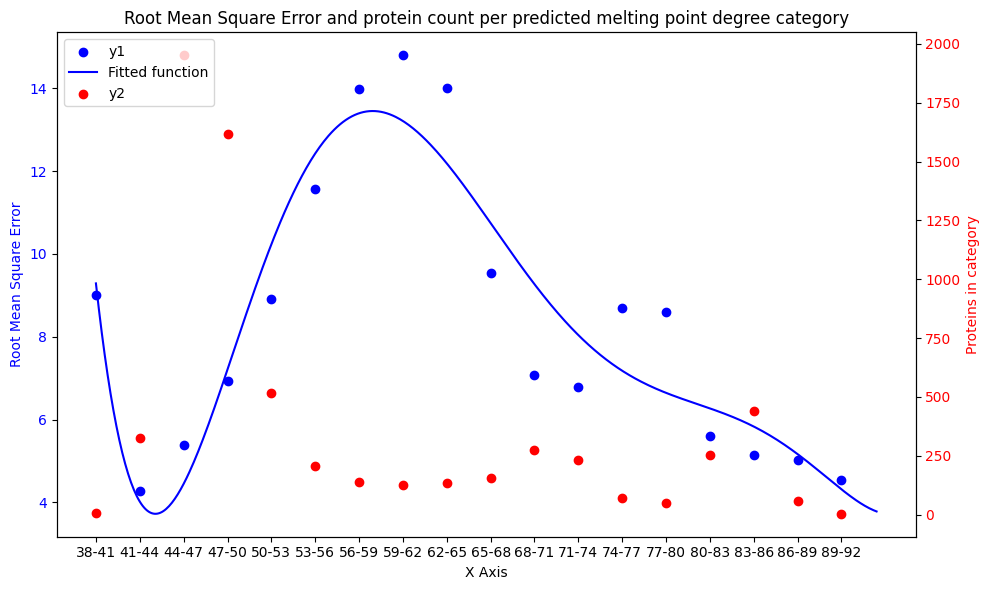

In [164]:
from scipy.optimize import curve_fit
def model_func(x, a,b,c,d,e,f,g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
x_values = np.array([39.5,42.5,45.5,48.5,51.5,54.5,57.5,60.5,63.5,66.5,69.5,72.5,75.5,78.5,81.5,84.5,87.5,90.5])
x_values2 = np.arange(39.5,93,0.1)
popt, pcov = curve_fit(model_func, x_values, grouped_rmse2['RMSE'])

print(f"Optimal parameters: {popt}")

fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.linspace(39, 93, 1)
# Scatter plot for y1
ax1.scatter(data =grouped_rmse2, x = x_values, y = 'RMSE', color='blue', label='y1')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Root Mean Square Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.scatter(data =grouped_rmse2, x = x_values, y = 'Count', color='red', label='y2')
ax2.set_ylabel('Proteins in category', color='red')
ax2.tick_params(axis='y', labelcolor='red')
x_fit = x_values2
y_fit = model_func(x_fit, *popt)
ax1.plot(x_fit, y_fit, color='blue', label='Fitted function')
# Add titles and legends
plt.title('Root Mean Square Error and protein count per predicted melting point degree category')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
plt.xticks(ticks=x_values, labels=grouped_rmse2.index)

plt.show()

In [101]:
grouped_rmse2.to_excel('./data/grouped_rmse2.xlsx',index = True)

In [119]:
def polynomial_function(x):
    return 0.00000007  * x**6 - 0.00003 * x**5 + 0.0056 * x**4 - 0.5173 * x**3 + 26.287 * x**2 - 696.87 * x + 7522.9
# y = 7E-08x6 - 3E-05x5 + 0,0056x4 - 0,5173x3 + 26,287x2 - 696,87x + 7522,9

In [120]:
polynomial_function(70)

2384.8299999999854

In [125]:
preetnshah = pd.read_csv('./data/cross-species.csv')
len(preetnshah['Protein_ID'].unique())

C:\Users\tobia\AppData\Local\Temp\ipykernel_5212\46586137.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  preetnshah = pd.read_csv('./data/cross-species.csv')


34282

In [131]:
len(prokaryotes1.columns)
len(model.feature_importances_)

25

In [137]:
len(np.array(range(25)))

25

In [138]:
feature_importances = pd.DataFrame({
    'Feature': np.array(range(25)),
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

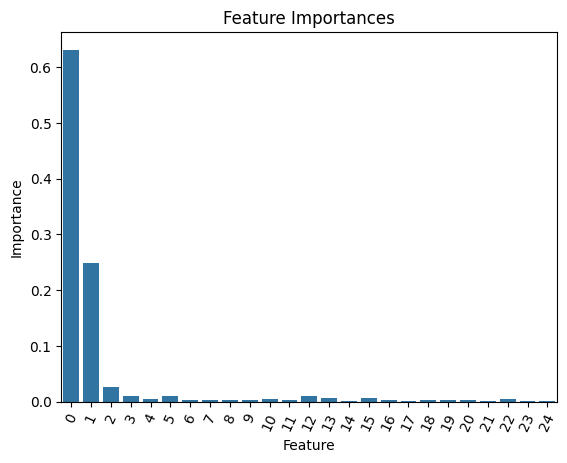

In [141]:
feature_importances = pd.DataFrame({
    'Feature': np.array(range(25)),
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Feature', y='Importance', data=feature_importances)
plt.title('Feature Importances')
plt.xticks(rotation=65)
plt.show()